# 5. Photographers at the Museum

```{sidebar} Datasets
  * [V&A collections](https://collections.vam.ac.uk/) and [API](https://developers.vam.ac.uk/)
```

```{sidebar} Libraries
  * [Python](https://www.python.org/)
  * [Pandas](https://pandas.pydata.org/)
  * [Vega](https://vega.github.io/vega/)
  * [Jupyter](https://jupyter.org/)
```

The V&A began acquiring photographs in 1852, and its [collection](https://www.vam.ac.uk/collections/photographs) is now one of the largest and most important in the world. Let's take a look at which photographers are held in the (catalogued) collection.

To query the photographers  in the V&A collections, we need to query object types of "photograph" and "photographs" (this is due to variations in cataloguing names) and cluster the results by 'maker'. We then show a treemap visualisation of the top 50 results for each.

For a record of the results, we also generate a sample of the photographers and some of their works as a PDF.

The following code (click to expand) setups the treemap drawing

In [4]:
from IPython.display import display

def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

def treemap(clusters, cluster_name):
    
  clusters_json = [{"id": index+1, "name": [x["value"], "%d objects" % x["count"]], "parent": '0', "value": x["count"]} for index, x in enumerate(clusters)]
  clusters_json.insert(0, {"id": 0, "value": 0, "name": cluster_name})
    
  Vega({
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 1200,
  "height": 800,
  "padding": 2.5,
  "autosize": "none",
  "data": [
    {
      "name": "tree",
      "values": clusters_json,
      "transform": [
        {
          "type": "stratify",
          "key": "id",
          "parentKey": "parent"
        },
        {
          "type": "treemap",
          "field": "value",
          "sort": {"field": "value", "order": "descending"},
          "round": True,
          "size": [{"signal": "width"}, {"signal": "height"}]
        }
      ]
    },
    {
      "name": "nodes",
      "source": "tree",
      "transform": [{ "type": "filter", "expr": "datum.children" }]
    },
    {
      "name": "leaves",
      "source": "tree",
      "transform": [{ "type": "filter", "expr": "datum.parent == 0" }]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "nodes", "field": "name"},
      "range": [
        "#3182bd", "#6baed6", "#9ecae1", "#c6dbef", "#e6550d",
        "#fd8d3c", "#fdae6b", "#fdd0a2", "#31a354", "#74c476",
        "#a1d99b", "#c7e9c0", "#756bb1", "#9e9ac8", "#bcbddc",
        "#dadaeb", "#636363", "#969696", "#bdbdbd", "#d9d9d9"
      ]
    },
    {
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [256, 10, 20, 14]
    },
    {
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0.15, 0.5, 0.8, 1.0]
    }
  ],

  "marks": [
    {
      "type": "rect",
      "from": {"data": "nodes"},
      "interactive": False,
      "encode": {
        "enter": {
          "fill": {"scale": "color", "field": "name"}
        },
        "update": {
          "x": {"field": "x0"},
          "y": {"field": "y0"},
          "x2": {"field": "x1"},
          "y2": {"field": "y1"}
        }
      }
    },
    {
      "type": "rect",
      "from": {"data": "leaves"},
      "encode": {
        "enter": {
          "stroke": {"value": "#fff"}
        },
        "update": {
          "x": {"field": "x0"},
          "y": {"field": "y0"},
          "x2": {"field": "x1"},
          "y2": {"field": "y1"},
          "fill": {"value": "transparent"},
          "href": {"value": "https://collections.vam.ac.uk/"}
        },
        "hover": {
          "fill": {"value": "green"}
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "leaves"},
      "interactive": False,
      "encode": {
        "enter": {
          "font": {"value": "Helvetica Neue, Arial"},
          "align": {"value": "center"},
          "baseline": {"value": "middle"},
          "fill": {"value": "#000"},
          "text": {"field": "name"},
          "fontSize": {"scale": "size", "field": "depth"},
          "fillOpacity": {"scale": "opacity", "field": "depth"}
        },
        "update": {
          "x": {"signal": "0.5 * (datum.x0 + datum.x1)"},
          "y": {"signal": "0.5 * (datum.y0 + datum.y1)"}
        }
      }
    }
  ]
}
)

## Data Visualisation

Now we query the API for the object types and show them as a treemap

### Photograph

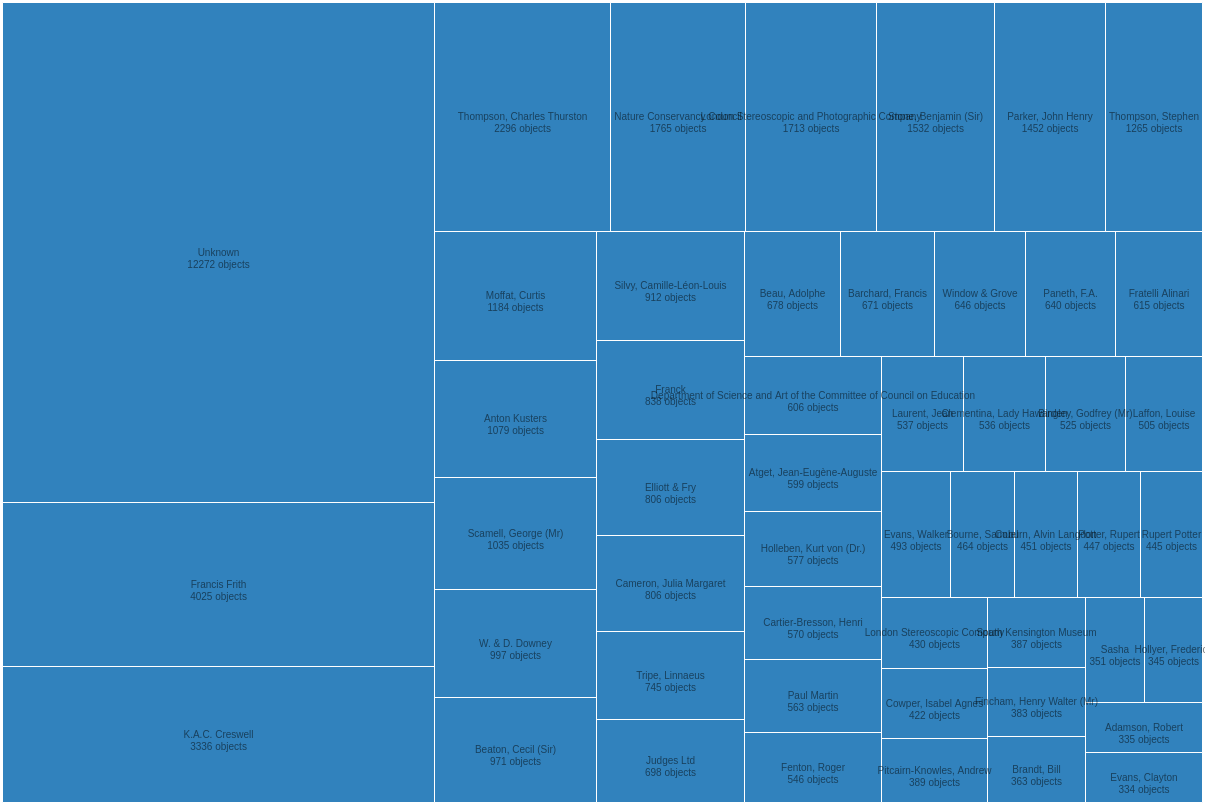

In [5]:
import requests
req = requests.get('https://api.vam.ac.uk/v2/objects/clusters/maker/search?kw_object_type=Photograph&cluster_size=50')
treemap(req.json(), "Photographers")

### Photographs

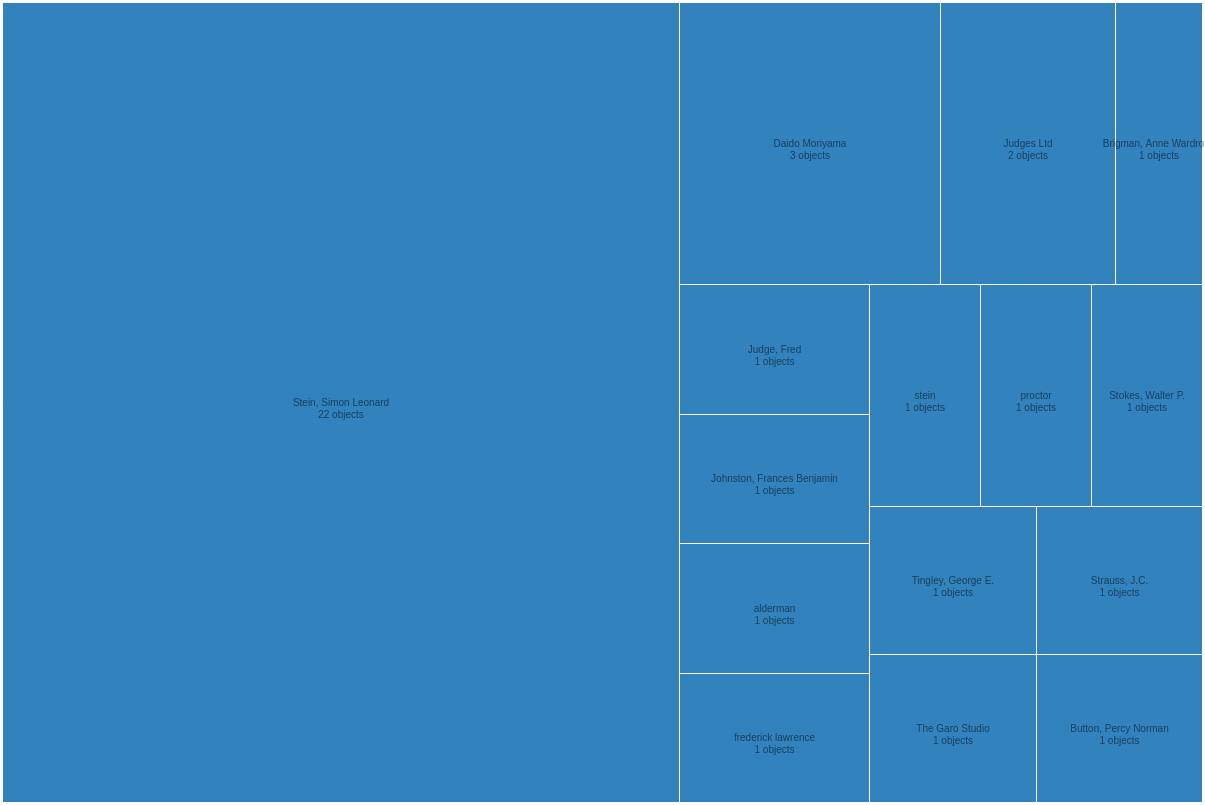

In [6]:
import requests
req = requests.get('https://api.vam.ac.uk/v2/objects/clusters/maker/search?kw_object_type=Photographs&cluster_size=50')
treemap(req.json(), "Photographer")

## Saving as CSV

At present we do not have a custom CSV response for cluster endpoints, this is something that might be added in a future version of the API. The response at the moment will return the identifier ('id'), a descriptive term ('value') and the count of matching object records ('count').

In [7]:
import pandas as pd
df_photograph = pd.read_json('https://api.vam.ac.uk/v2/objects/clusters/maker/search?kw_object_type=Photograph&cluster_size=100', orient='records')
df_photograph["link"] = "https://collections.vam.ac.uk/search/?id_person=" + df_photograph['id']
df_photograph.to_csv("photograph-top-100-link.csv")
df_photograph.head(10)

,id,value,count,count_max_error,link
0,A1848,Unknown,12272,0,https://collections.vam.ac.uk/search/?id_perso...
1,A6403,Francis Frith,4025,0,https://collections.vam.ac.uk/search/?id_perso...
2,AUTH334543,K.A.C. Creswell,3336,0,https://collections.vam.ac.uk/search/?id_perso...
3,N3687,"Thompson, Charles Thurston",2296,0,https://collections.vam.ac.uk/search/?id_perso...
4,AUTH391620,Nature Conservancy Council,1765,0,https://collections.vam.ac.uk/search/?id_perso...
5,A5970,London Stereoscopic and Photographic Company,1713,0,https://collections.vam.ac.uk/search/?id_perso...
6,A4801,"Stone, Benjamin (Sir)",1532,0,https://collections.vam.ac.uk/search/?id_perso...
7,AUTH325233,"Parker, John Henry",1452,0,https://collections.vam.ac.uk/search/?id_perso...
8,AUTH335751,"Thompson, Stephen",1265,0,https://collections.vam.ac.uk/search/?id_perso...
9,A12876,"Moffat, Curtis",1184,0,https://collections.vam.ac.uk/search/?id_perso...


In [8]:

import pandas as pd
df_photographs = pd.read_json('https://api.vam.ac.uk/v2/objects/clusters/maker/search?kw_object_type=photographs&cluster_size=100', orient='records')
# Making it easier for ourselves later on
df_photographs["link"] = "https://collections.vam.ac.uk/search/?id_person=" + df_photographs['id']
df_photographs.to_csv("photographs-top-100-link.csv")

In [10]:
import requests
req = requests.get('https://api.vam.ac.uk/v2/objects/clusters/maker/search?kw_object_type=Photograph&cluster_size=50')
top50_photographers = req.json()

## Generating PDF sample

A possibly useful way to look at the data, for those who don't want to just see spreadsheets and data tables, is to construct a PDF with a sample of objects for each photograph. This code (drawn from reportlab documentation) generates a very simple PDF with images of 5 objects for the first 10 photographers.

In [23]:
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch
import PIL
from io import BytesIO
import requests
import pandas as pd

PAGE_HEIGHT=defaultPageSize[1]; 
PAGE_WIDTH=defaultPageSize[0]
styles = getSampleStyleSheet()
top100_photographs = ""

Title = "V&A Photographers - Top 50"
pageinfo = "vam-api-data-exploration-5"

def myFirstPage(canvas, doc): 
    canvas.saveState() 
    canvas.setFont('Times-Bold',16)  
    canvas.drawCentredString(PAGE_WIDTH/2.0, PAGE_HEIGHT-108, Title) 
    canvas.setFont('Times-Roman',9) 
    canvas.drawString(inch, 0.75 * inch, "First Page / %s" % pageinfo) 
    canvas.restoreState()

def myLaterPages(canvas, doc): 
    canvas.saveState()  
    canvas.setFont('Times-Roman',9)   
    canvas.drawString(inch, 0.75 * inch, "Page %d %s" % (doc.page, pageinfo)) 
    canvas.restoreState()

chart_style = TableStyle([('ALIGN', (0, 0), (-1, -1), 'CENTER')])

def build_doc():  
    doc = SimpleDocTemplate("photographers-samples.pdf") 
    Story = [Spacer(1,2*inch)]  
    style = styles["Normal"]  
    
    i = 0
    for photographer in top50_photographers:
        photographer_name = photographer['value']   
        photographer_id = photographer['id']
        
        # Retrieve an image to show, update URL to point directly to thumbnail derivative
        query_url = "https://api.vam.ac.uk/v2/objects/search?id_maker=%s&images_exist=1&response_format=csv&page_size=20" % photographer_id
        photograph_objects = pd.read_csv(query_url)
        IIIF_IMAGE_URL = "https://framemark.vam.ac.uk/collections/%s/full/!100,100/0/default.jpg"
        if len(photograph_objects) < 1:
            continue

        p = Paragraph(photographer_name, style)     
        Story.append(p)   
        Story.append(Spacer(1,0.4*inch)) 
            
        photograph_objects._primaryImageId = [IIIF_IMAGE_URL % item for item in photograph_objects._primaryImageId]      

        r = requests.get(photograph_objects.iloc[0]._primaryImageId)
        image1 = Image(BytesIO(r.content), width=inch, height=inch)
        if not pd.isna(photograph_objects.iloc[0]._primaryTitle):
          object_link = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[0].systemNumber, photograph_objects.iloc[0]._primaryTitle))
        else:
          object_link = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[0].systemNumber, photograph_objects.iloc[0].objectType))
        
        r = requests.get(photograph_objects.iloc[1]._primaryImageId)
        image2 = Image(BytesIO(r.content), width=inch, height=inch)
        if not pd.isna(photograph_objects.iloc[0]._primaryTitle):
          object_link2 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[1].systemNumber, photograph_objects.iloc[1]._primaryTitle))
        else:
          object_link2 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[1].systemNumber, photograph_objects.iloc[1].objectType))        
    
        
        r = requests.get(photograph_objects.iloc[2]._primaryImageId)
        image3 = Image(BytesIO(r.content), width=inch, height=inch)
        if not pd.isna(photograph_objects.iloc[0]._primaryTitle):
          object_link3 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[2].systemNumber, photograph_objects.iloc[2]._primaryTitle))
        else:
          object_link3 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[2].systemNumber, photograph_objects.iloc[2].objectType))
            
        r = requests.get(photograph_objects.iloc[3]._primaryImageId)
        image4 = Image(BytesIO(r.content), width=inch, height=inch)
        if not pd.isna(photograph_objects.iloc[0]._primaryTitle):
          object_link4 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[3].systemNumber, photograph_objects.iloc[3]._primaryTitle))
        else:
          object_link4 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[3].systemNumber, photograph_objects.iloc[3].objectType))
            
        r = requests.get(photograph_objects.iloc[4]._primaryImageId)
        image5 = Image(BytesIO(r.content), width=inch, height=inch)
        if not pd.isna(photograph_objects.iloc[0]._primaryTitle):
          object_link5 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[4].systemNumber, photograph_objects.iloc[4]._primaryTitle))
        else:
          object_link5 = Paragraph('<link href="https://collections.vam.ac.uk/item/%s">%s</link>' % (photograph_objects.iloc[4].systemNumber, photograph_objects.iloc[4].objectType))        
        
        Story.append(Table([[image1, image2, image3, image4, image5], [object_link, object_link2, object_link3, object_link4, object_link5]],
                     colWidths=[inch, inch, inch, inch, inch],
                     rowHeights=[ 0.75*inch, 0.25*inch], style=chart_style))
        
        Story.append(Spacer(1,0.2*inch)) 
        if i > 9:
            break
        else:
            i += 1
      
    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)
 
req = requests.get('https://api.vam.ac.uk/v2/objects/clusters/maker/search?kw_object_type=Photograph&cluster_size=50')
top50_photographers = req.json()

build_doc()
    


In [ ]:
# DO NOT REMOVE This code is just here to force Jupyterbook to generate the diagrams as PNGs above. It's hidden from the output

import altair as alt
import plotly as px

data = px.data.iris()
data.head()

alt.Chart(data=data).mark_point().encode(
    x="sepal_width",
    y="sepal_length",
    color="species",
    size='sepal_length'
)

In [ ]:
# Notebook Updates

## 24 June 2024

  * Revised report generation code to be slightly better output (still can be improved!)